In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as Layer
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

import tensorflow_io as tfio

import importlib
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
# logical_gpus = tf.config.experimental.list_logical_devices('GPU')
# print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
print("Tensorflow version: ", tf.__version__)
print("Tensorflow GPU detection: ", tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.5.0
Tensorflow GPU detection:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DATA_PATH = '../data/G2Net/g2net-gravitational-wave-detection/'
MODEL_PATH = '../data/G2Net/models'
TB_LOG_PATH = '../data/G2Net/tb_logs'
AUTOTUNE = tf.data.AUTOTUNE

SPLIT_RATIO = .9
RANDOM_STATE = 27

IMG_WIDTH = 55
IMG_HEIGHT = 129


In [4]:
train = tf.data.experimental.load(os.path.join(DATA_PATH, 'ds_train_full')).map(lambda data, label: (tf.math.minimum(data, .99), label))
valid = tf.data.experimental.load(os.path.join(DATA_PATH, 'ds_valid_full')).map(lambda data, label: (tf.math.minimum(data, .99), label))
# train = tf.data.experimental.load(os.path.join(DATA_PATH, 'ds_train_base_poc'))
# valid = tf.data.experimental.load(os.path.join(DATA_PATH, 'ds_valid_base_poc'))

In [5]:
# def prep(img, label):
#     ret = preprocess_input(img)
#     return ret,label

In [6]:
BATCH_SIZE = 16

# train_data = train.take(250000).map(prep).batch(BATCH_SIZE).prefetch(buffer_size=64)
# valid_data = valid.take(25000).map(prep).cache().batch(BATCH_SIZE).prefetch(buffer_size=64)
# train_data = train.take(200000).batch(BATCH_SIZE).prefetch(buffer_size=64)
# valid_data = valid.take(20000).batch(BATCH_SIZE).prefetch(buffer_size=64)
train_data = train.batch(BATCH_SIZE).prefetch(buffer_size=64)
valid_data = valid.batch(BATCH_SIZE).prefetch(buffer_size=64)


In [7]:
min_value = 1
max_value = 0
for data, label in train.take(100):
#     data = (tfio.audio.dbscale(data+1 , 1)) / 10
    local_max = np.amax(data.numpy())
    if  local_max > max_value:
        max_value = local_max 
    local_min = np.amin(data.numpy())
    if  local_min < min_value:
        min_value = local_min 

print(train.cardinality)
print("Min value: ", min_value)
print("Max value: ", max_value)

<bound method DatasetV2.cardinality of <MapDataset shapes: (<unknown>, ()), types: (tf.float32, tf.float32)>>
Min value:  1.7919106e-06
Max value:  0.99


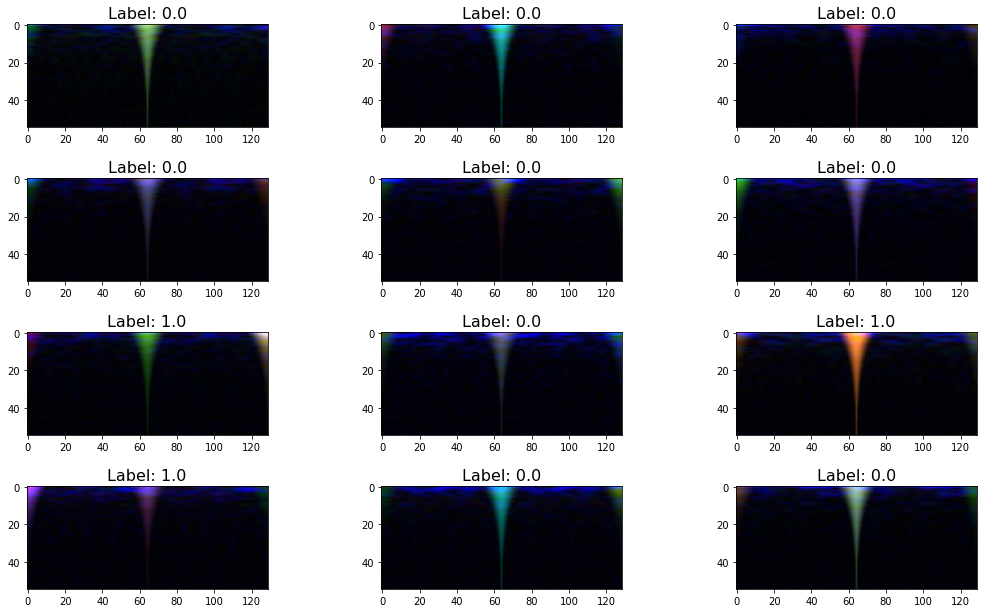

Min value:  1
Max value:  0


In [8]:
from matplotlib import pyplot as plt
fig,a =  plt.subplots(4,3, figsize=(18,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)
cpt = 0
min_value = 1
max_value = 0
for data, label in train.skip(15).take(12):
#     data = (tfio.audio.dbscale(data+1 , 40)) / 11
    line = cpt % 3
    col = cpt // 3
    a[col, line].imshow(data)
    a[col, line].set_title(
            'Label: ' + str(label.numpy()),
            fontsize=16)
    cpt = cpt + 1

plt.show()
print("Min value: ", min_value)
print("Max value: ", max_value)


In [9]:
print(train_data.cardinality)

<bound method DatasetV2.cardinality of <PrefetchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.float32)>>


In [10]:
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.applications.efficientnet import preprocess_input

base_model = EfficientNetB5(
    include_top=False,
    input_shape=(IMG_WIDTH, IMG_HEIGHT,3),
    weights='imagenet',
    pooling='max',
    drop_connect_rate=0.3)

# base_model = ResNet50V2(
#     weights='imagenet',
# #     weights=None,
#     include_top=False,
#     input_shape=(IMG_WIDTH, IMG_HEIGHT,3),
#     pooling='avg')
# base_model.trainable=True
# base_model.trainable=False


# fine_tune_at = 171
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable =  False

In [11]:
metrics = [tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.BinaryAccuracy(name='Accuracy'),]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=4e-4,
    decay_steps=10000,
    decay_rate=0.85)

tb_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(TB_LOG_PATH,'full_b5_dec85_4e4'),
    update_freq=64,
    )



callbacks= [
    tb_callback,
]

def create_model(alpha):
    model = tf.keras.Sequential([
        Layer.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT,3)),
        Layer.BatchNormalization(),
#         Layer.LeakyReLU(alpha=alpha),
#         Layer.Lambda(preprocess_input),
        base_model,
#         Layer.GlobalAveragePooling2D(name="avg_pool"),
        Layer.BatchNormalization(),
        Layer.LeakyReLU(alpha=alpha),
        Layer.Dropout(.3, name="top_dropout_1"),
        Layer.Dense(64),
        Layer.LeakyReLU(alpha=alpha),
        Layer.Dropout(.3, name="top_dropout_2"),
        Layer.Dense(32),
        Layer.LeakyReLU(alpha=alpha),
#         Layer.Dropout(.3, name="top_dropout_2"),
        Layer.Dense(1, activation='sigmoid')])

    return model

In [12]:
model = create_model(.2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 55, 129, 3)        12        
_________________________________________________________________
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
top_dropout_1 (Dropout)      (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0

In [13]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  577


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=metrics)

In [ ]:
model.fit(
    train_data,
    epochs=1,
    validation_data=valid_data,
    callbacks = callbacks,
    )

c:\users\vince\miniconda3\envs\ml38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


 9398/31500 [=======>......................] - ETA: 1:09:25 - loss: 0.5213 - AUC: 0.7952 - Accuracy: 0.7331

In [18]:
model.save(os.path.join(MODEL_PATH,'full_b5_dec85_4e4'))

c:\users\vince\miniconda3\envs\ml38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../data/G2Net/models\full_b5_dec95_4e4\assets


In [16]:
pred = model.predict(train_data.take(20))

In [17]:
print(pred)

[[0.8 ]
 [0.24]
 [0.55]
 [1.  ]
 [0.39]
 [0.39]
 [0.35]
 [0.51]
 [0.56]
 [0.36]
 [0.74]
 [1.  ]
 [0.24]
 [0.67]
 [0.45]
 [1.  ]
 [0.41]
 [0.35]
 [0.3 ]
 [0.38]
 [0.59]
 [0.6 ]
 [1.  ]
 [0.48]
 [0.78]
 [0.31]
 [0.36]
 [0.35]
 [0.42]
 [1.  ]
 [0.27]
 [0.41]
 [0.55]
 [0.56]
 [1.  ]
 [0.24]
 [0.56]
 [0.97]
 [0.3 ]
 [0.38]
 [0.64]
 [0.57]
 [0.56]
 [0.73]
 [0.79]
 [0.38]
 [0.34]
 [1.  ]
 [0.37]
 [0.42]
 [0.58]
 [0.76]
 [0.65]
 [0.4 ]
 [0.37]
 [1.  ]
 [0.62]
 [0.69]
 [0.29]
 [0.34]
 [0.62]
 [0.34]
 [0.34]
 [1.  ]
 [0.29]
 [0.25]
 [0.75]
 [0.65]
 [0.37]
 [1.  ]
 [0.73]
 [1.  ]
 [1.  ]
 [1.  ]
 [1.  ]
 [0.96]
 [0.26]
 [0.31]
 [0.42]
 [0.27]
 [0.63]
 [0.65]
 [0.27]
 [0.29]
 [0.28]
 [0.35]
 [0.98]
 [1.  ]
 [0.57]
 [0.45]
 [0.28]
 [0.36]
 [0.81]
 [0.87]
 [0.47]
 [0.36]
 [0.74]
 [0.37]
 [1.  ]
 [0.85]
 [0.35]
 [0.39]
 [0.32]
 [1.  ]
 [0.78]
 [1.  ]
 [0.36]
 [0.38]
 [0.45]
 [0.25]
 [0.64]
 [0.46]
 [0.36]
 [1.  ]
 [0.37]
 [0.51]
 [0.75]
 [0.99]
 [0.3 ]
 [0.4 ]
 [0.51]
 [0.55]
 [0.28]
 [0.39]
 [0.3 ]


In [16]:
for data, label in train_data.skip(100).take(1):
    print(data)

tf.Tensor(
[[[[0.48 0.36 0.61]
   [0.48 0.34 0.61]
   [0.45 0.33 0.64]
   ...
   [0.11 0.91 0.28]
   [0.11 0.96 0.19]
   [0.12 0.97 0.14]]

  [[0.42 0.27 0.62]
   [0.42 0.27 0.62]
   [0.39 0.26 0.6 ]
   ...
   [0.09 0.79 0.29]
   [0.1  0.84 0.32]
   [0.1  0.85 0.33]]

  [[0.32 0.24 0.06]
   [0.32 0.23 0.1 ]
   [0.29 0.22 0.17]
   ...
   [0.08 0.69 0.35]
   [0.09 0.73 0.39]
   [0.09 0.75 0.39]]

  ...

  [[0.   0.   0.02]
   [0.01 0.01 0.03]
   [0.01 0.01 0.05]
   ...
   [0.01 0.01 0.01]
   [0.   0.01 0.06]
   [0.   0.01 0.03]]

  [[0.   0.   0.01]
   [0.01 0.01 0.03]
   [0.   0.01 0.06]
   ...
   [0.   0.01 0.03]
   [0.   0.   0.06]
   [0.   0.01 0.03]]

  [[0.01 0.01 0.05]
   [0.01 0.01 0.01]
   [0.   0.   0.02]
   ...
   [0.01 0.   0.04]
   [0.   0.01 0.04]
   [0.   0.01 0.01]]]


 [[[0.58 0.16 0.63]
   [0.58 0.16 0.65]
   [0.55 0.15 0.65]
   ...
   [0.02 0.51 0.11]
   [0.   0.54 0.12]
   [0.01 0.55 0.13]]

  [[0.49 0.15 0.44]
   [0.49 0.15 0.43]
   [0.46 0.15 0.4 ]
   ...
   [0.02 0

In [17]:
for data, label in valid_data.skip(100).take(1):
    print(data)

tf.Tensor(
[[[[0.07 0.1  0.59]
   [0.05 0.11 0.59]
   [0.05 0.11 0.59]
   ...
   [0.51 0.2  0.53]
   [0.54 0.21 0.51]
   [0.56 0.22 0.51]]

  [[0.07 0.08 0.24]
   [0.07 0.09 0.22]
   [0.08 0.08 0.2 ]
   ...
   [0.41 0.12 0.26]
   [0.44 0.13 0.2 ]
   [0.45 0.12 0.17]]

  [[0.09 0.08 0.14]
   [0.1  0.07 0.14]
   [0.08 0.07 0.15]
   ...
   [0.34 0.11 0.48]
   [0.37 0.11 0.48]
   [0.37 0.11 0.5 ]]

  ...

  [[0.01 0.   0.02]
   [0.01 0.01 0.09]
   [0.   0.   0.02]
   ...
   [0.01 0.01 0.05]
   [0.   0.   0.02]
   [0.01 0.   0.01]]

  [[0.01 0.   0.08]
   [0.01 0.01 0.07]
   [0.01 0.   0.02]
   ...
   [0.01 0.01 0.04]
   [0.02 0.   0.03]
   [0.01 0.   0.02]]

  [[0.02 0.   0.03]
   [0.01 0.   0.04]
   [0.02 0.01 0.03]
   ...
   [0.01 0.01 0.06]
   [0.01 0.01 0.03]
   [0.01 0.   0.05]]]


 [[[0.03 0.18 1.05]
   [0.04 0.18 1.05]
   [0.04 0.18 1.  ]
   ...
   [0.55 0.2  0.8 ]
   [0.57 0.21 0.72]
   [0.59 0.23 0.69]]

  [[0.05 0.17 0.56]
   [0.05 0.17 0.55]
   [0.05 0.16 0.52]
   ...
   [0.4  0